## Visualizing the effect of scaling methods

Adapted from:

Raschka, S. "About feature scaling and normalization–and the effect of standardization for machine learning algorithms. Sebastian Raschka. 2014." (2014).
Accessed from: https://sebastianraschka.com/Articles/2014_about_feature_scaling.html

In [7]:
import itertools
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics


import kdquantile

,Class label,Alcohol,Malic acid
0,1,14.23,1.71
1,1,13.20,1.78
2,1,13.16,2.36
3,1,14.37,1.95
4,1,13.24,2.59



z-score transform
Alcohol 	 mean:-0.00 stddev:1.00 min:-2.43 max:2.26
Malic acid 	 mean:-0.00 stddev:1.00 min:-1.43 max:3.11

min-max transform
Alcohol 	 mean:0.52 stddev:0.21 min:0.00 max:1.00
Malic acid 	 mean:0.32 stddev:0.22 min:0.00 max:1.00

quantile transform
Alcohol 	 mean:0.50 stddev:0.29 min:0.00 max:1.00
Malic acid 	 mean:0.50 stddev:0.29 min:0.00 max:1.00

KD-quantile transform
Alcohol 	 mean:0.51 stddev:0.26 min:0.00 max:1.00
Malic acid 	 mean:0.42 stddev:0.27 min:0.00 max:1.00


/Users/calvinm/miniconda3/envs/ksquantile/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:2667: UserWarning: n_quantiles (1000) is greater than the total number of samples (178). n_quantiles is set to n_samples.
  warnings.warn(


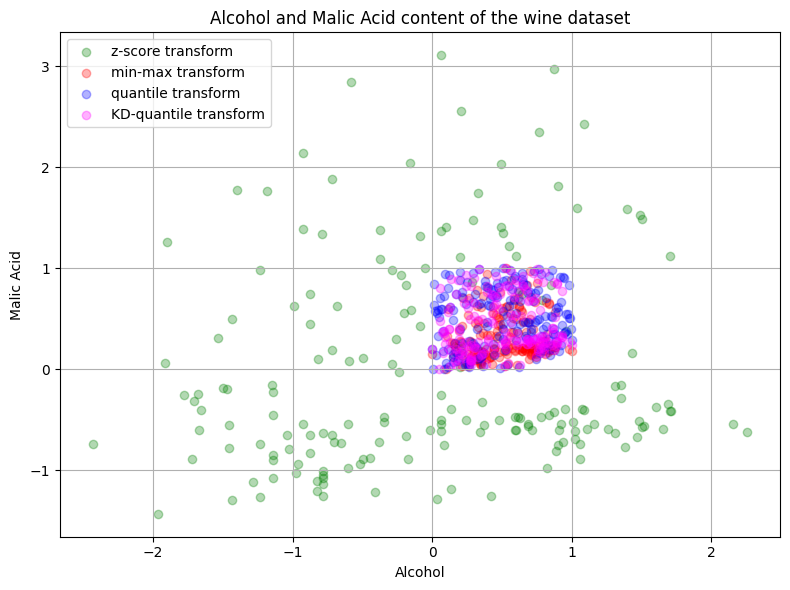

In [2]:
columns = [
    'Class label',
    'Alcohol', 'Malic acid', 'Ash', 'Ash alcalinity',
    'Magnesium', 'Total phenols', 'Flavanoids',
    'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 
    'Hue', 'OD280/OD315 of diluted wines', 'Proline'
]
df = pd.io.parsers.read_csv('wine_data.csv', header=None, usecols=[0,1,2])
df.columns = columns[0:3]
display(df.head())

def describe_transform(raw_df, preprocessor, cur_label, cur_color):
    chosen_features = ['Alcohol', 'Malic acid']
    prepper = preprocessor().fit(raw_df[chosen_features])
    prepped_df = prepper.transform(raw_df[chosen_features])

    print('\n'+cur_label)
    for ix, feat in enumerate(chosen_features):
        col = prepped_df[:,ix]
        print('{} \t mean:{:.2f} stddev:{:.2f} min:{:.2f} max:{:.2f}'.format(
            feat, col.mean(), col.std(), col.min(), col.max()))

    plt.gca().scatter(prepped_df[:,0], prepped_df[:,1], color=cur_color,
        label=cur_label, alpha=0.3)

plt.figure(figsize=(8,6))
describe_transform(df, preprocessing.StandardScaler, 'z-score transform', 'green')
describe_transform(df, preprocessing.MinMaxScaler, 'min-max transform', 'red')
describe_transform(df, preprocessing.QuantileTransformer, 'quantile transform', 'blue')
describe_transform(df, kdquantile.KDQuantileTransformer, 'KD-quantile transform', 'magenta')
plt.title('Alcohol and Malic Acid content of the wine dataset')
plt.xlabel('Alcohol')
plt.ylabel('Malic Acid')
plt.legend(loc='upper left')
plt.grid()
plt.tight_layout()

## The effect of standardization on PCA in a pattern classification task

/Users/calvinm/miniconda3/envs/ksquantile/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:2667: UserWarning: n_quantiles (1000) is greater than the total number of samples (124). n_quantiles is set to n_samples.
  warnings.warn(


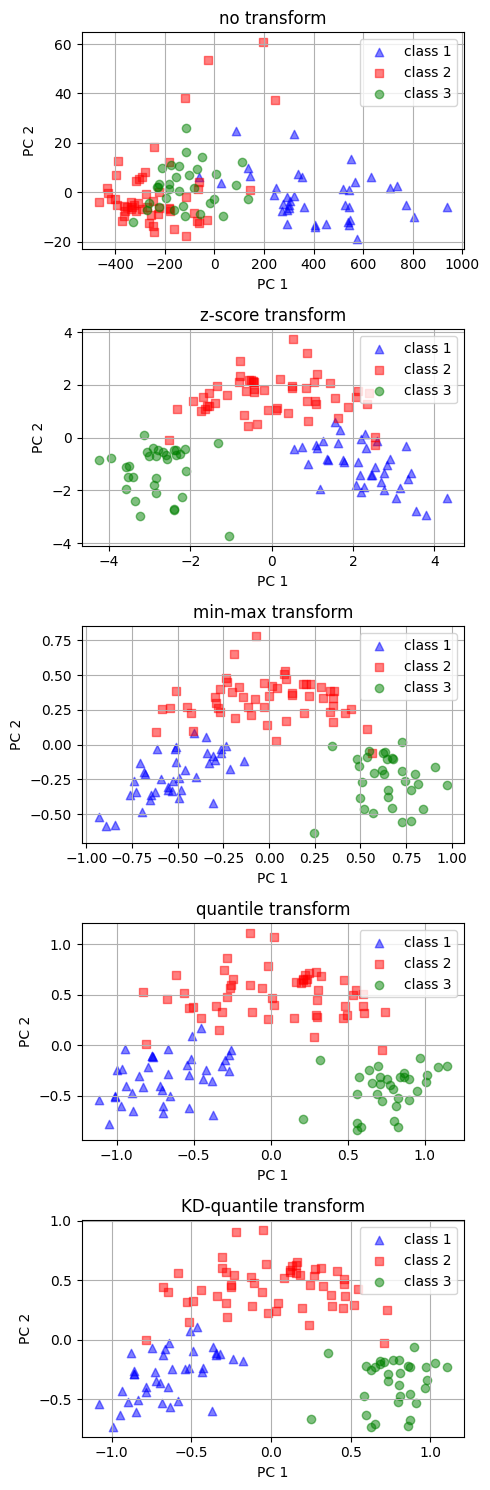

Transform 	 Train+Full 	 Train+PCA 	 Test+Full 	 Test+PCA
no          	 98.39% 	 81.45% 	 98.15% 	 64.81%
z-score     	 98.39% 	 96.77% 	 98.15% 	 98.15%
min-max     	 98.39% 	 96.77% 	 98.15% 	 100.00%
quantile    	 97.58% 	 97.58% 	 100.00% 	 96.30%
KD-quantile 	 97.58% 	 98.39% 	 100.00% 	 100.00%


In [3]:
df = pd.io.parsers.read_csv('wine_data.csv', header=None)
X_wine = df.values[:,1:]
y_wine = df.values[:,0]

X_train, X_test, y_train, y_test = train_test_split(
    X_wine, y_wine,
    test_size=0.30, random_state=12345)

X_dict = {}

# On raw data
pca = PCA(n_components=2).fit(X_train)
X_train_pc = pca.transform(X_train)
X_test_pc = pca.transform(X_test)
X_dict['no'] = {
    'train': {'pc': X_train_pc, 'full': X_train}, 
    'test': {'pc': X_test_pc, 'full': X_test},
}

# On preprocessed data
methods = [
    (preprocessing.StandardScaler, 'z-score'),
    (preprocessing.MinMaxScaler, 'min-max'),
    (preprocessing.QuantileTransformer, 'quantile'),
    (kdquantile.KDQuantileTransformer, 'KD-quantile'),
]
for preprocessor, pname in methods:
    prepper = preprocessor().fit(X_train)
    X_train_prepped = prepper.transform(X_train)
    X_test_prepped = prepper.transform(X_test)
    pcaer = PCA(n_components=2).fit(X_train_prepped)
    X_train_prepped_pc = pcaer.transform(X_train_prepped)
    X_test_prepped_pc = pcaer.transform(X_test_prepped)
    X_dict[pname] = {
        'train': {'pc': X_train_prepped_pc, 'full': X_train_prepped},
        'test': {'pc': X_test_prepped_pc, 'full': X_test_prepped},
    }

fig, axes = plt.subplots(nrows=len(X_dict), figsize=(5,3*len(X_dict)))

for ax, pname in zip(axes, list(X_dict.keys())):
    X_pc = X_dict[pname]['train']['pc']
    for l,c,m in zip(range(1,4), ('blue', 'red', 'green'), ('^', 's', 'o')):
        ax.scatter(X_pc[y_train==l, 0], X_pc[y_train==l, 1],
            color=c, label='class %s' % l, alpha=0.5, marker=m
        )
    ax.set_title('{} transform'.format(pname))    
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    ax.legend(loc='upper right')
    ax.grid()

plt.tight_layout()
plt.show()

print('Transform \t Train+Full \t Train+PCA \t Test+Full \t Test+PCA')
res_dict = {}
for pname in list(X_dict.keys()):
    gnb_full = GaussianNB()    
    gnb_pc = GaussianNB()
    gnb_full.fit(X_dict[pname]['train']['full'], y_train)
    gnb_pc.fit(X_dict[pname]['train']['pc'], y_train)
    pred_train_full = gnb_full.predict(X_dict[pname]['train']['full'])
    pred_train_pc = gnb_pc.predict(X_dict[pname]['train']['pc'])
    pred_test_full = gnb_full.predict(X_dict[pname]['test']['full'])
    pred_test_pc = gnb_pc.predict(X_dict[pname]['test']['pc'])
    acc_train_full = metrics.accuracy_score(y_train, pred_train_full)
    acc_train_pc = metrics.accuracy_score(y_train, pred_train_pc)
    acc_test_full = metrics.accuracy_score(y_test, pred_test_full)
    acc_test_pc = metrics.accuracy_score(y_test, pred_test_pc)
    print(f'{pname:<11} \t {acc_train_full:.2%} \t {acc_train_pc:.2%} \t {acc_test_full:.2%} \t {acc_test_pc:.2%}')
    #res_dict[pname] = {'Test+Full': acc_test_full, 'Test+PCA': acc_test_pc}
    res_dict[pname] = {
        'train': {'pc': acc_train_pc, 'full': acc_train_full},
        'test': {'pc': acc_test_pc, 'full': acc_test_full},
    }

In [4]:
n_random = 100
n_alphas = 20
alphas = list(np.geomspace(0.1, 10, n_alphas))
methods = [
    (preprocessing.StandardScaler, 'z-score'),
    (preprocessing.MinMaxScaler, 'min-max'),
    (preprocessing.QuantileTransformer, 'quantile'),
    (kdquantile.KDQuantileTransformer, 'KD-quantile'),
]
random_states = list(np.random.randint(0, 12345, size=n_random))
test_dict = {}
for mname in ['no']+[mname for _, mname in methods]:
    test_dict[mname] = {'pc': np.zeros(n_random), 'full': np.zeros(n_random)}

alpha_dict = {'pc': np.zeros((n_random, n_alphas)), 'full': np.zeros((n_random, n_alphas))}
for rix, rstate in enumerate(random_states):
    X_train, X_test, y_train, y_test = train_test_split(
        X_wine, y_wine, test_size=0.30, random_state=rstate)
    
    pca = PCA(n_components=2).fit(X_train)
    X_train_pc = pca.transform(X_train)
    X_test_pc = pca.transform(X_test)
    gnb_full = GaussianNB().fit(X_train, y_train)
    gnb_pc = GaussianNB().fit(X_train_pc, y_train)
    acc_test_full = metrics.accuracy_score(y_test, gnb_full.predict(X_test))
    acc_test_pc = metrics.accuracy_score(y_test, gnb_pc.predict(X_test_pc))
    test_dict['no']['full'][rix] = acc_test_full
    test_dict['no']['pc'][rix] = acc_test_pc
    
    for preprocessor, pname in methods:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            prepper = preprocessor().fit(X_train)
        X_train_prepped = prepper.transform(X_train)
        X_test_prepped = prepper.transform(X_test)
        pcaer = PCA(n_components=2).fit(X_train_prepped)
        X_train_prepped_pc = pcaer.transform(X_train_prepped)
        X_test_prepped_pc = pcaer.transform(X_test_prepped)

        gnb_full = GaussianNB().fit(X_train_prepped, y_train)
        gnb_pc = GaussianNB().fit(X_train_prepped_pc, y_train)
        acc_test_full = metrics.accuracy_score(y_test, gnb_full.predict(X_test_prepped))
        acc_test_pc = metrics.accuracy_score(y_test, gnb_pc.predict(X_test_prepped_pc))
        test_dict[pname]['full'][rix] = acc_test_full
        test_dict[pname]['pc'][rix] = acc_test_pc

    for aix, alpha in enumerate(alphas):
        prepper = kdquantile.KDQuantileTransformer(alpha=alpha).fit(X_train)
        X_train_prepped = prepper.transform(X_train)
        X_test_prepped = prepper.transform(X_test)
        pcaer = PCA(n_components=2).fit(X_train_prepped)
        X_train_prepped_pc = pcaer.transform(X_train_prepped)
        X_test_prepped_pc = pcaer.transform(X_test_prepped)
        gnb_full = GaussianNB().fit(X_train_prepped, y_train)
        gnb_pc = GaussianNB().fit(X_train_prepped_pc, y_train)
        acc_test_full = metrics.accuracy_score(y_test, gnb_full.predict(X_test_prepped))
        acc_test_pc = metrics.accuracy_score(y_test, gnb_pc.predict(X_test_prepped_pc))
        alpha_dict['pc'][rix, aix] = acc_test_pc
        alpha_dict['full'][rix, aix] = acc_test_full

for dname in ['full', 'pc']:
    for mname in ['no']+[mname for _, mname in methods]:
        mean = np.mean(test_dict[mname][dname])
        print(f'{mname:<11} {dname:<5} {mean:.4%}')
for dname in ['full', 'pc']:
    mean = np.mean(alpha_dict[dname], axis=0)
    print(f'{dname:<5} {mean}')


no          full  97.4444%
z-score     full  97.4630%
min-max     full  97.4630%
quantile    full  98.1296%
KD-quantile full  97.7222%
no          pc    74.2407%
z-score     pc    96.2407%
min-max     pc    97.0556%
quantile    pc    96.1852%
KD-quantile pc    97.4630%
full  [0.98166667 0.98185185 0.98148148 0.98166667 0.98148148 0.98111111
 0.9812963  0.98055556 0.97925926 0.97740741 0.97666667 0.97611111
 0.97407407 0.97351852 0.97351852 0.97314815 0.97277778 0.97277778
 0.97314815 0.97333333]
pc    [0.9612963  0.96185185 0.96277778 0.96425926 0.96537037 0.96648148
 0.96851852 0.9712963  0.97388889 0.97388889 0.97462963 0.97388889
 0.97425926 0.97407407 0.97259259 0.97259259 0.97203704 0.97240741
 0.97240741 0.97240741]


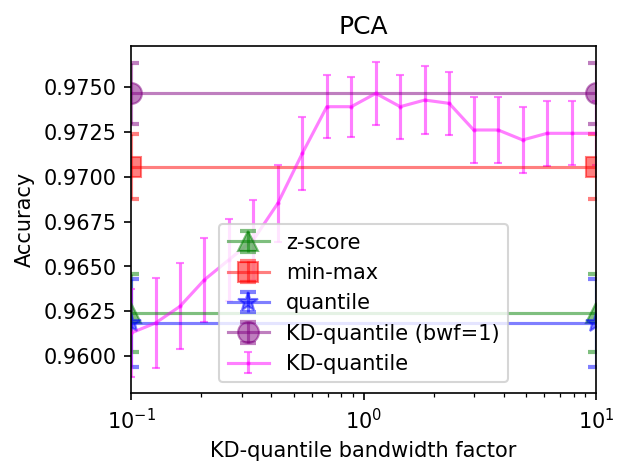

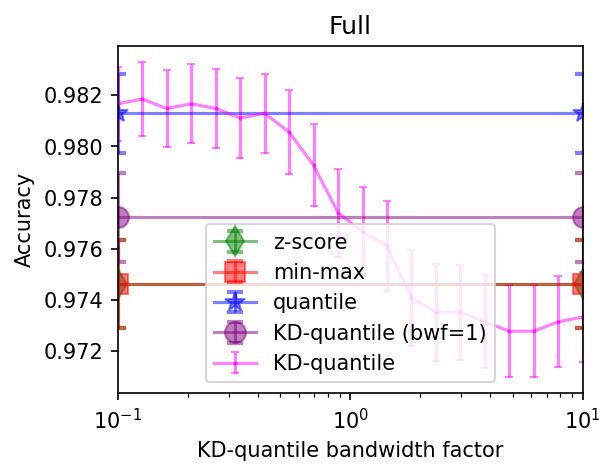

In [6]:
markers = itertools.cycle(('^', 's', '*', 'o', '.'))
colors = itertools.cycle(('green', 'red', 'blue', 'purple', 'magenta')) 
alph = np.array([np.min(alphas), np.max(alphas)]);
fig = plt.figure(figsize=(4,3), dpi=150)
for pname in list(res_dict.keys()):
    if pname == 'no':
        continue
    tmean = test_dict[pname]['pc'].mean()
    tstd = np.std(test_dict[pname]['pc'], ddof=1) / np.sqrt(n_random)
    (_, caps, _) = plt.errorbar(
        alph, tmean*np.ones(2), yerr=tstd*np.ones(2), 
        marker=next(markers), c = next(colors), markersize=10, alpha=0.5, capsize=4,
        label=f'{pname} (bwf=1)' if pname=='KD-quantile' else pname);
    for cap in caps:
        cap.set_markeredgewidth(2)
amean = alpha_dict['pc'].mean(axis=0)
astd = np.std(alpha_dict['pc'], axis=0, ddof=1) / np.sqrt(n_random)
plt.errorbar(
    alphas, amean, yerr=astd,
    marker=next(markers), c=next(colors), markersize=2, alpha=0.5, capsize=2,
    label='KD-quantile');
plt.xlabel('KD-quantile bandwidth factor');
plt.ylabel('Accuracy');
plt.xscale('log');
plt.legend(loc='lower center');
#plt.grid();
plt.xlim(np.min(alphas), np.max(alphas));
fig.savefig('accuracy-vs-bwf-wine-pca.pdf', bbox_inches='tight')
plt.title('PCA');

markers = itertools.cycle(('d', 's', '*', 'o', '.'))
colors = itertools.cycle(('green', 'red', 'blue', 'purple', 'magenta')) 
fig = plt.figure(figsize=(4,3), dpi=150)
for pname in list(res_dict.keys()):
    if pname == 'no':
        continue
    tmean = test_dict[pname]['full'].mean()
    tstd = np.std(test_dict[pname]['full'], ddof=1) / np.sqrt(n_random)
    (_, caps, _) = plt.errorbar(
        alph, tmean*np.ones(2), yerr=tstd*np.ones(2), 
        marker=next(markers), c = next(colors), markersize=10, alpha=0.5, capsize=4,
        label=f'{pname} (bwf=1)' if pname=='KD-quantile' else pname);
    for cap in caps:
        cap.set_markeredgewidth(2)
amean = alpha_dict['full'].mean(axis=0)
astd = np.std(alpha_dict['full'], axis=0, ddof=1) / np.sqrt(n_random)
plt.errorbar(
    alphas, amean, yerr=astd,
    marker=next(markers), c=next(colors), markersize=2, alpha=0.5, capsize=2,
    label='KD-quantile');
plt.legend(loc='lower center');
plt.xlabel('KD-quantile bandwidth factor');
plt.xscale('log');
plt.ylabel('Accuracy');
#plt.grid();
plt.xlim(np.min(alphas), np.max(alphas));
fig.savefig('accuracy-vs-bwf-wine-full.pdf', bbox_inches='tight')
plt.title('Full');

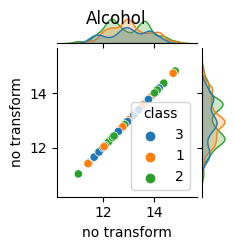

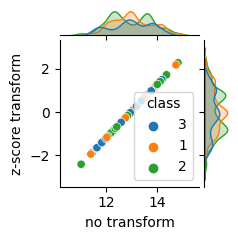

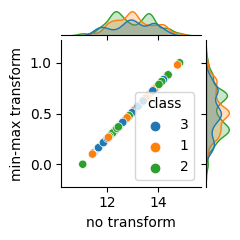

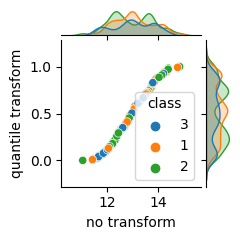

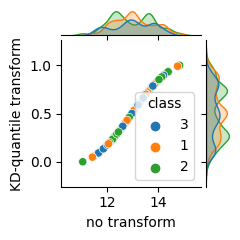

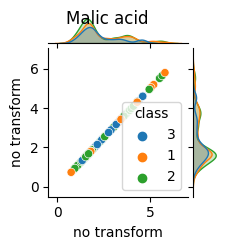

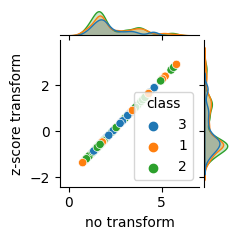

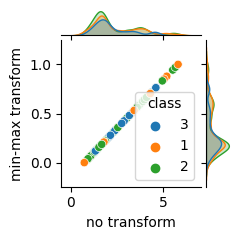

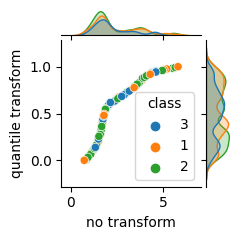

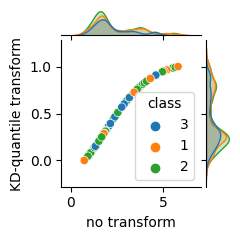

In [60]:
for fix, fname in enumerate(columns[1:3]):
    cols = [
        X_dict[pname]['train']['full'][:, [fix]] for pname in list(X_dict.keys())
    ]
    df = pd.DataFrame(np.concatenate(cols, axis=1), columns=[_+" transform" for _ in X_dict.keys()])
    df['class'] = y_train.reshape(-1, 1).astype('int').astype('str')
    for pix, pname in enumerate(list(X_dict.keys())):
        grid = sns.jointplot(data=df, x='no transform', y=f'{pname} transform', hue='class', marginal_kws=dict(bw_adjust=0.5),height=2.5)
        sns.move_legend(plt.gca(), 'lower right')
        if pix == 0:
            grid.fig.suptitle(fname)
            grid.fig.subplots_adjust(top=0.95)
        else:
            grid.fig.savefig(f'jointplot-wine-{fname}-{pname}.pdf');